# <span> Laboratorio di Simulazione Numerica  </span>
## <span> Esercitazione 7 </span>

In questa esercitazione viene simulato un insieme di particelle interagenti tramite un potenziale di Lennard-Jones sfruttando l'algoritmo di <b>Metropolis</b> nell'insieme canonico, ovvero a temperatura fissata. In particolare, come nella quarta esercitazione, simuliamo un campione di <b>Argon</b> ( $\sigma=0.34$ nm, $\epsilon /k_B = 120$ K, $m = 39.948$ amu) nelle tre fasi solida, liquida e gassosa, delle quali ricordiamo le condizioni termodinamiche:

- <span><b>Fase solida</b>: $\rho*=1.1$, $T*=0.8$,  $r_c*=2.2$</span>
- <span><b>Fase liquida</b>: $\rho*=0.8$, $T*=1.1$,  $r_c*=2.5$</span>
- <span><b>Fase gassosa</b>: $\rho*=0.05$, $T*=1.2$,  $r_c*=5.0$</span>

L'obiettivo è quello di misurare l'energia potenziale per particella $U/N$, la pressione $P$ e la funzione di distribuzione radiale a coppie del sistema $g(r)$. <br>
In questa esercitazione è stato utilizzato il codice Monte Carlo NVT fornitoci in laboratorio, opportunamente completato nei seguenti esercizi.

### Esercizio 7.1

Le incertezze statistiche delle quantità che misureremo in questa esercitazione sono calcolate tramite il metodo del data blocking. Tuttavia, le configurazioni generate dall'algoritmo di Metropolis sono correlate tra loro, il che non ci permette di considerare una lunghezza qualsiasi del blocco. <br> 
Lo scopo di questo primo esercizio è proprio quello di determinare una corretta dimensione dei blocchi in modo che le medie di blocco siano statisticamente indipendenti, così da poter usare il CLT per determinare l'errore statistico sulle stime ottenute come medie.

Dato che stiamo usando l'algoritmo di Metropolis, la prima fase è sempre l'<b>equilibrazione</b> del sistema: monitoriamo quindi l'andamento di energia potenziale e pressione a ogni step dell'algoritmo finchè tali valori non iniziano a oscillare attorno a un determinato valore. Di seguiti vengono riportati i primi $2000$ valori istantanei di tali quantità per tutte e tre le fasi simulate.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants as const
from scipy.constants import physical_constants

e_kb = 120
e = e_kb * const.k
sigma = 0.34e-9
p = e/(sigma**3)

%config InlineBackend.figure_format = 'retina'

In [2]:
step, epot_eq_solid, pres_eq_solid = np.loadtxt("MonteCarlo_NVT/Solid/eq_solid.out", usecols=(0,1,2), delimiter=' ', unpack='true')
epot_solid, pres_solid = np.loadtxt("MonteCarlo_NVT/Solid/ac_solid.out", usecols=(1,2), delimiter=' ', unpack='true')
epot_eq_liquid, pres_eq_liquid = np.loadtxt("MonteCarlo_NVT/Liquid/eq_liquid.out", usecols=(1,2), delimiter=' ', unpack='true')
epot_liquid, pres_liquid = np.loadtxt("MonteCarlo_NVT/Liquid/ac_liquid.out", usecols=(1,2), delimiter=' ', unpack='true')
epot_eq_gas, pres_eq_gas = np.loadtxt("MonteCarlo_NVT/Gas/eq_gas.out", usecols=(1,2), delimiter=' ', unpack='true')
epot_gas, pres_gas = np.loadtxt("MonteCarlo_NVT/Gas/ac_gas.out", usecols=(1,2), delimiter=' ', unpack='true')

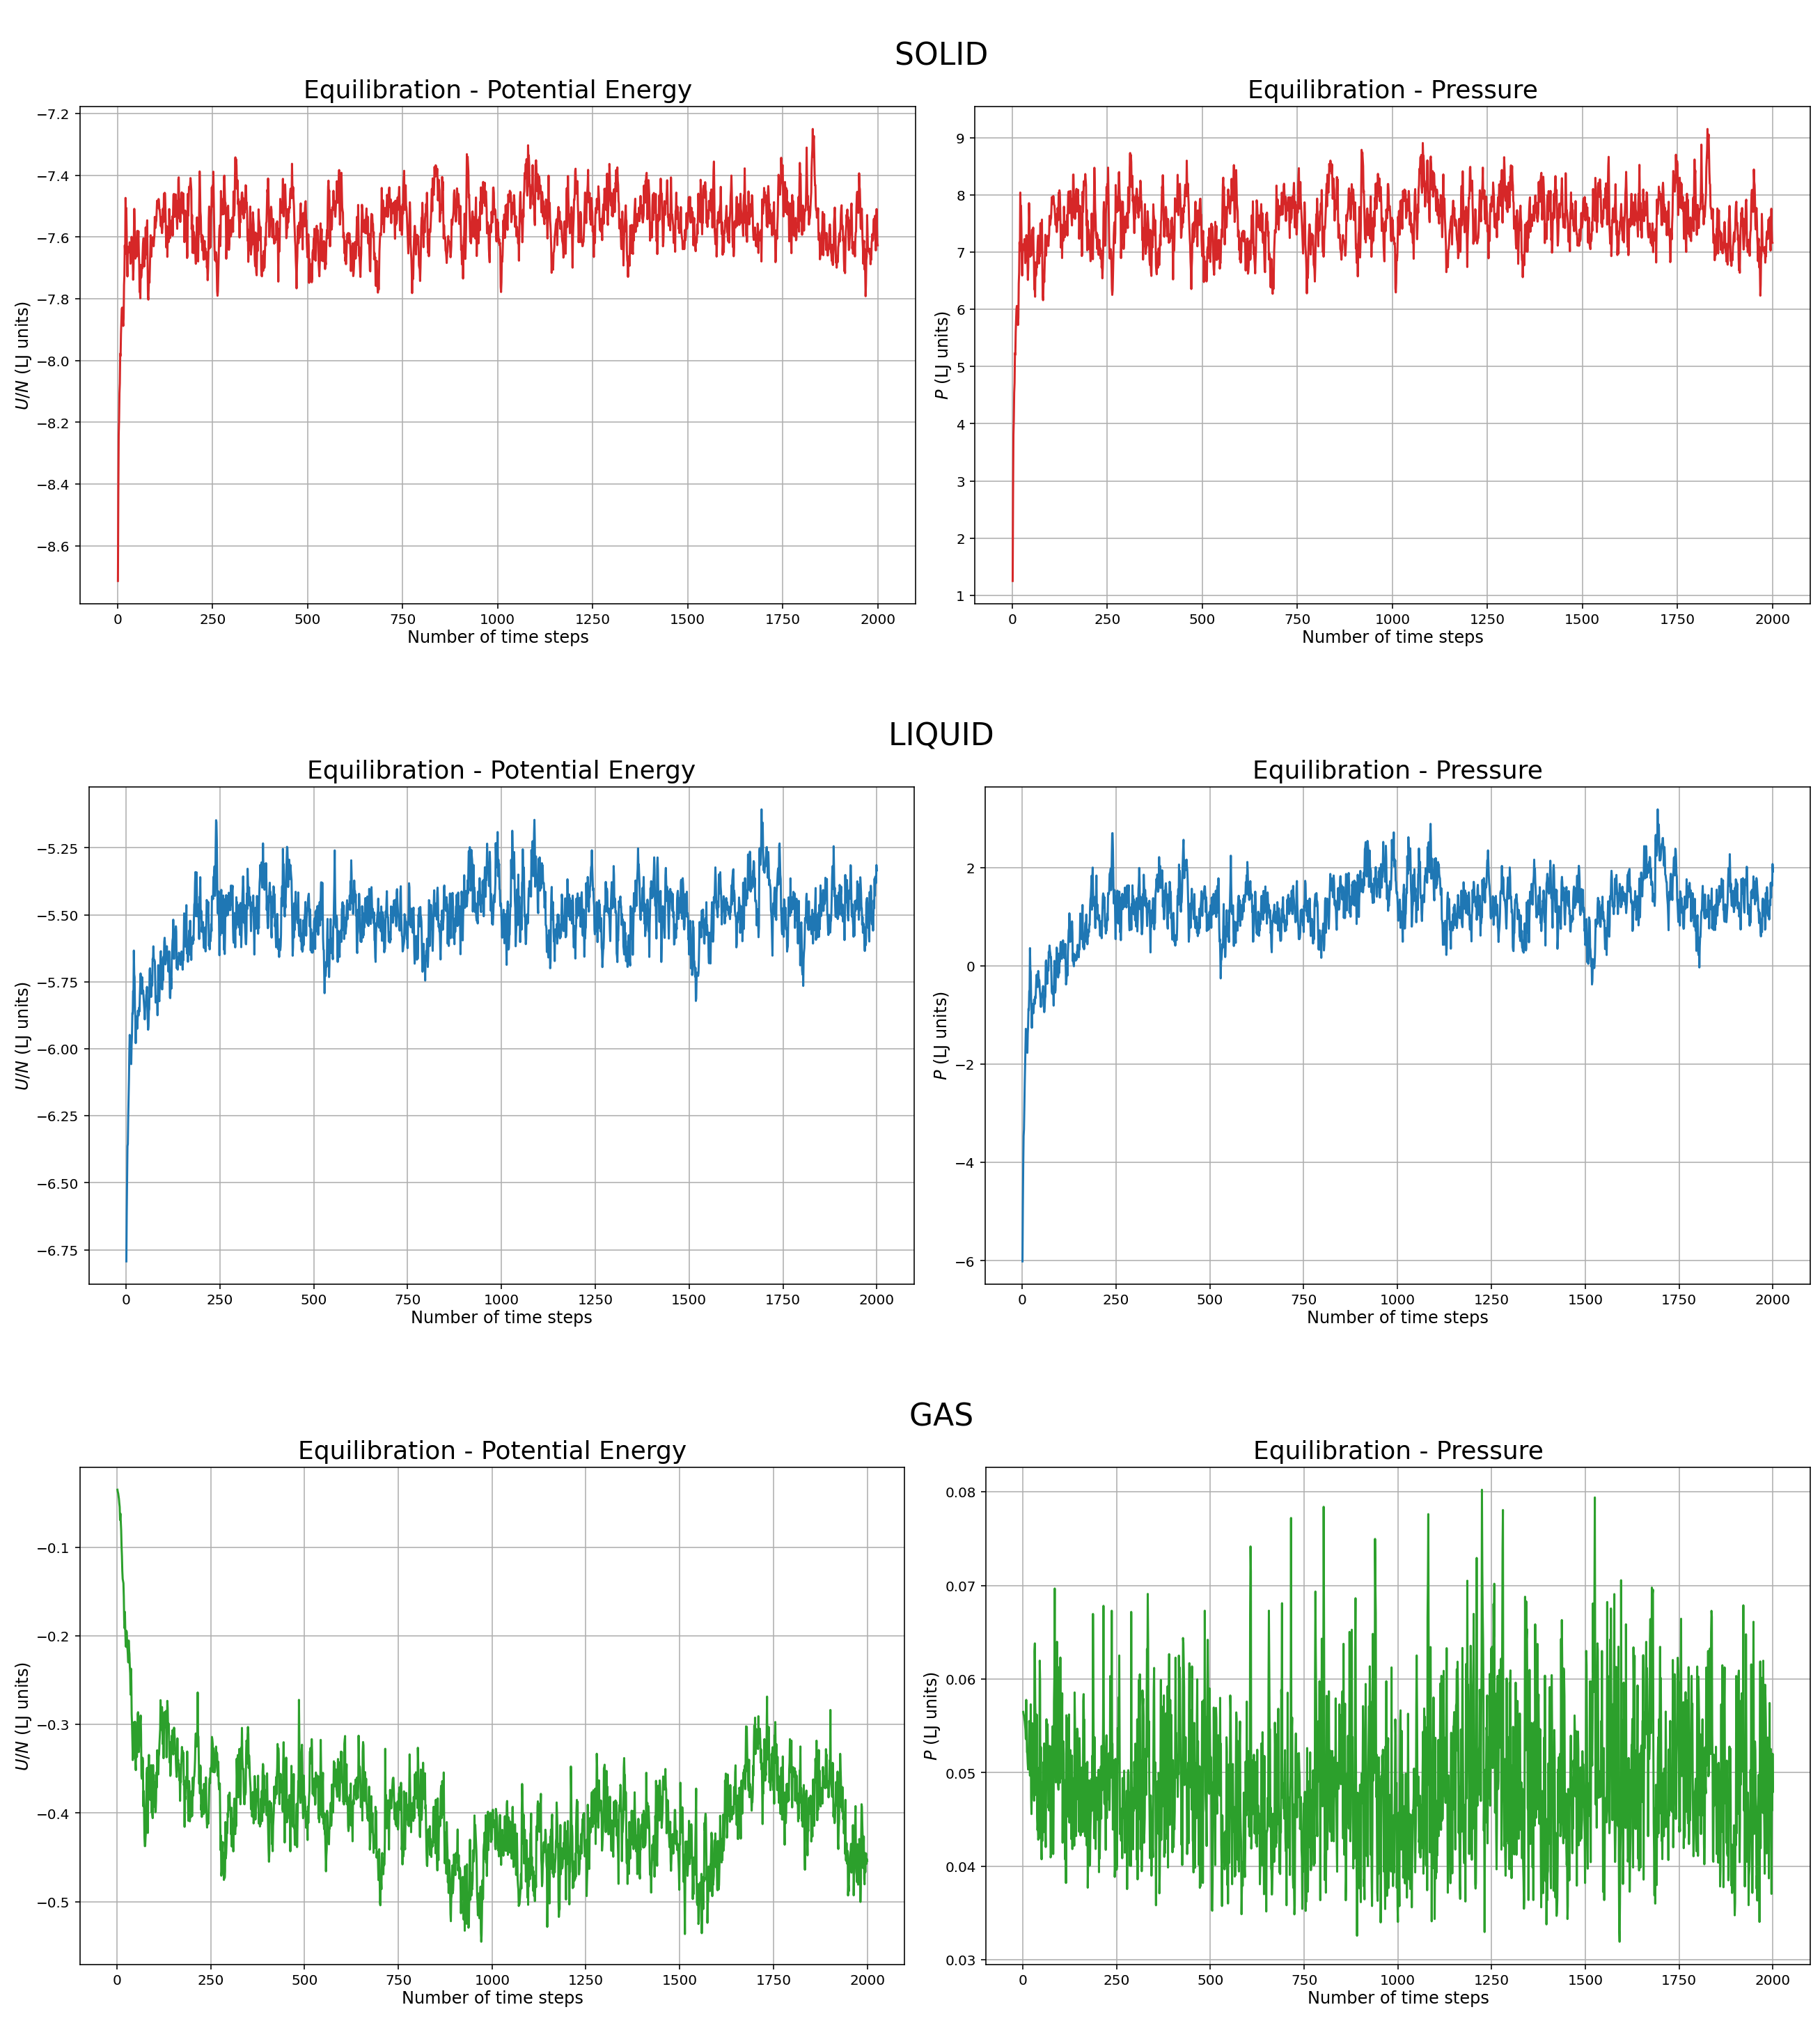

In [3]:
fig = plt.figure(constrained_layout=True, figsize=(18, 20))
fig.suptitle('  ', fontsize='xx-large')

bigtitle_list = ['SOLID', 'LIQUID', 'GAS']
title_list = ['Equilibration - Potential Energy', 'Equilibration - Pressure']
y_list = ['$U/N$ (LJ units)', '$P$ (LJ units)']
color_list = ['tab:red', 'tab:blue', 'tab:green']
plot_list = [epot_eq_solid, pres_eq_solid, epot_eq_liquid, pres_eq_liquid, epot_eq_gas, pres_eq_gas]

subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0.1)

for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'      {bigtitle_list[row]}', fontsize=22)
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        ax.plot(step, plot_list[col+row*2], color=color_list[row])
        ax.set_xlabel(r'Number of time steps', fontsize=12)
        ax.set_ylabel(f'{y_list[col]}', fontsize=12)
        ax.set_title(f'{title_list[col]}', fontsize=18)
        ax.grid(True)

Come si può vedere dai grafici qui sopra, $500$ step sono sufficienti per equilibrare l'algoritmo in tutte e tre le fasi.

Equilibrato il sistema, viene calibrato il rate di accettazione dell'algortimo di Metropolis: ad ogni step dell'algoritmo vengono mosse le particelle estraendo uniformemente tre numeri  nell'intervallo $[-\delta, \delta]$ con cui modificheremo le tre coordinate di una particella estratta casualmente. Il parametro $\delta$ è libero e viene fissato dalla regola empirica del $50 \%$. I parametri utilizzati per tale parametro nelle tre fasi sono i seguenti: 

- <span>$\delta_s$ = 0.11</span>
- <span>$\delta_l = 0.2$</span>
- <span>$\delta_g$ = 15.0</span>

Rispetto alle fasi solida e liquida, nel gas si ha un grande aumento del parametro $\delta$. Questo si può spiegare osservando che, a parità di numero di particelle, queste sono poco interagenti tra loro e sono mediamente più distanti rispetto a quanto lo sarebbero nelle altre due fasi; di conseguenza, il volume in cui sono racchiuse è maggiore.

Possiamo ora procedere con l'analisi della corretta dimensione dei blocchi. Innanzitutto vengono generati per tutte e tre le fasi $5 \cdot 10^5$ valori istantanei di pressione ed energia potenziale sui quali andremo a fare le nostre analisi statistiche. Il primo passo consiste nel determinare dopo quanti step le configurazioni generate dall'algoritmo sono scorrelate. Per fare ciò calcoliamo la <b>funzione di autocorrelazione</b>, che per tempi discreti è definita nel modo seguente

$$Ac_{[x]} (t) = \frac{\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t} x(t') x(t'+t)-\left(\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t} x(t') \right) \left(\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t} x(t'+t) \right)}{\frac{1}{t_{max}}\sum_{t'=0}^{t_{max}} x^2(t')-\left(\frac{1}{t_{max}}\sum_{t'=0}^{t_{max}} x(t') \right)^2}$$

dove $x$ è la grandezza presa in considerazione, $t$ è la distanza temporale tra le grandezze misurate e $t_{max}$ è la distanza temporale massima tra le configurazioni considerate (per noi  $t_{max} = 5 \cdot 10^5$) . Di seguito sono riportati i risultati ottenuti per valori di $t$ fino a $400$.

In [4]:
def ACF(x, tn, tmax):
    ac = np.zeros(tn)
    #tmax = x.size
    for t in range(tn):
        ac[t] = (np.sum(x[0:tmax-t]*x[t:tmax])/(tmax-t)-(np.sum(x[0:tmax-t])*np.sum(x[t:tmax]))/(tmax-t)**2)/(np.sum(x[:tmax]*x[:tmax])/tmax-(np.sum(x[:tmax])/tmax)**2)
    return ac

In [5]:
epot_ac_solid = ACF(epot_solid, 400, epot_solid.size)
pres_ac_solid = ACF(pres_solid, 400, pres_solid.size)
epot_ac_liquid = ACF(epot_liquid, 400, epot_liquid.size)
pres_ac_liquid = ACF(pres_liquid, 400, pres_liquid.size)
epot_ac_gas = ACF(epot_gas, 400, epot_gas.size)
pres_ac_gas = ACF(pres_gas, 400, pres_gas.size) 

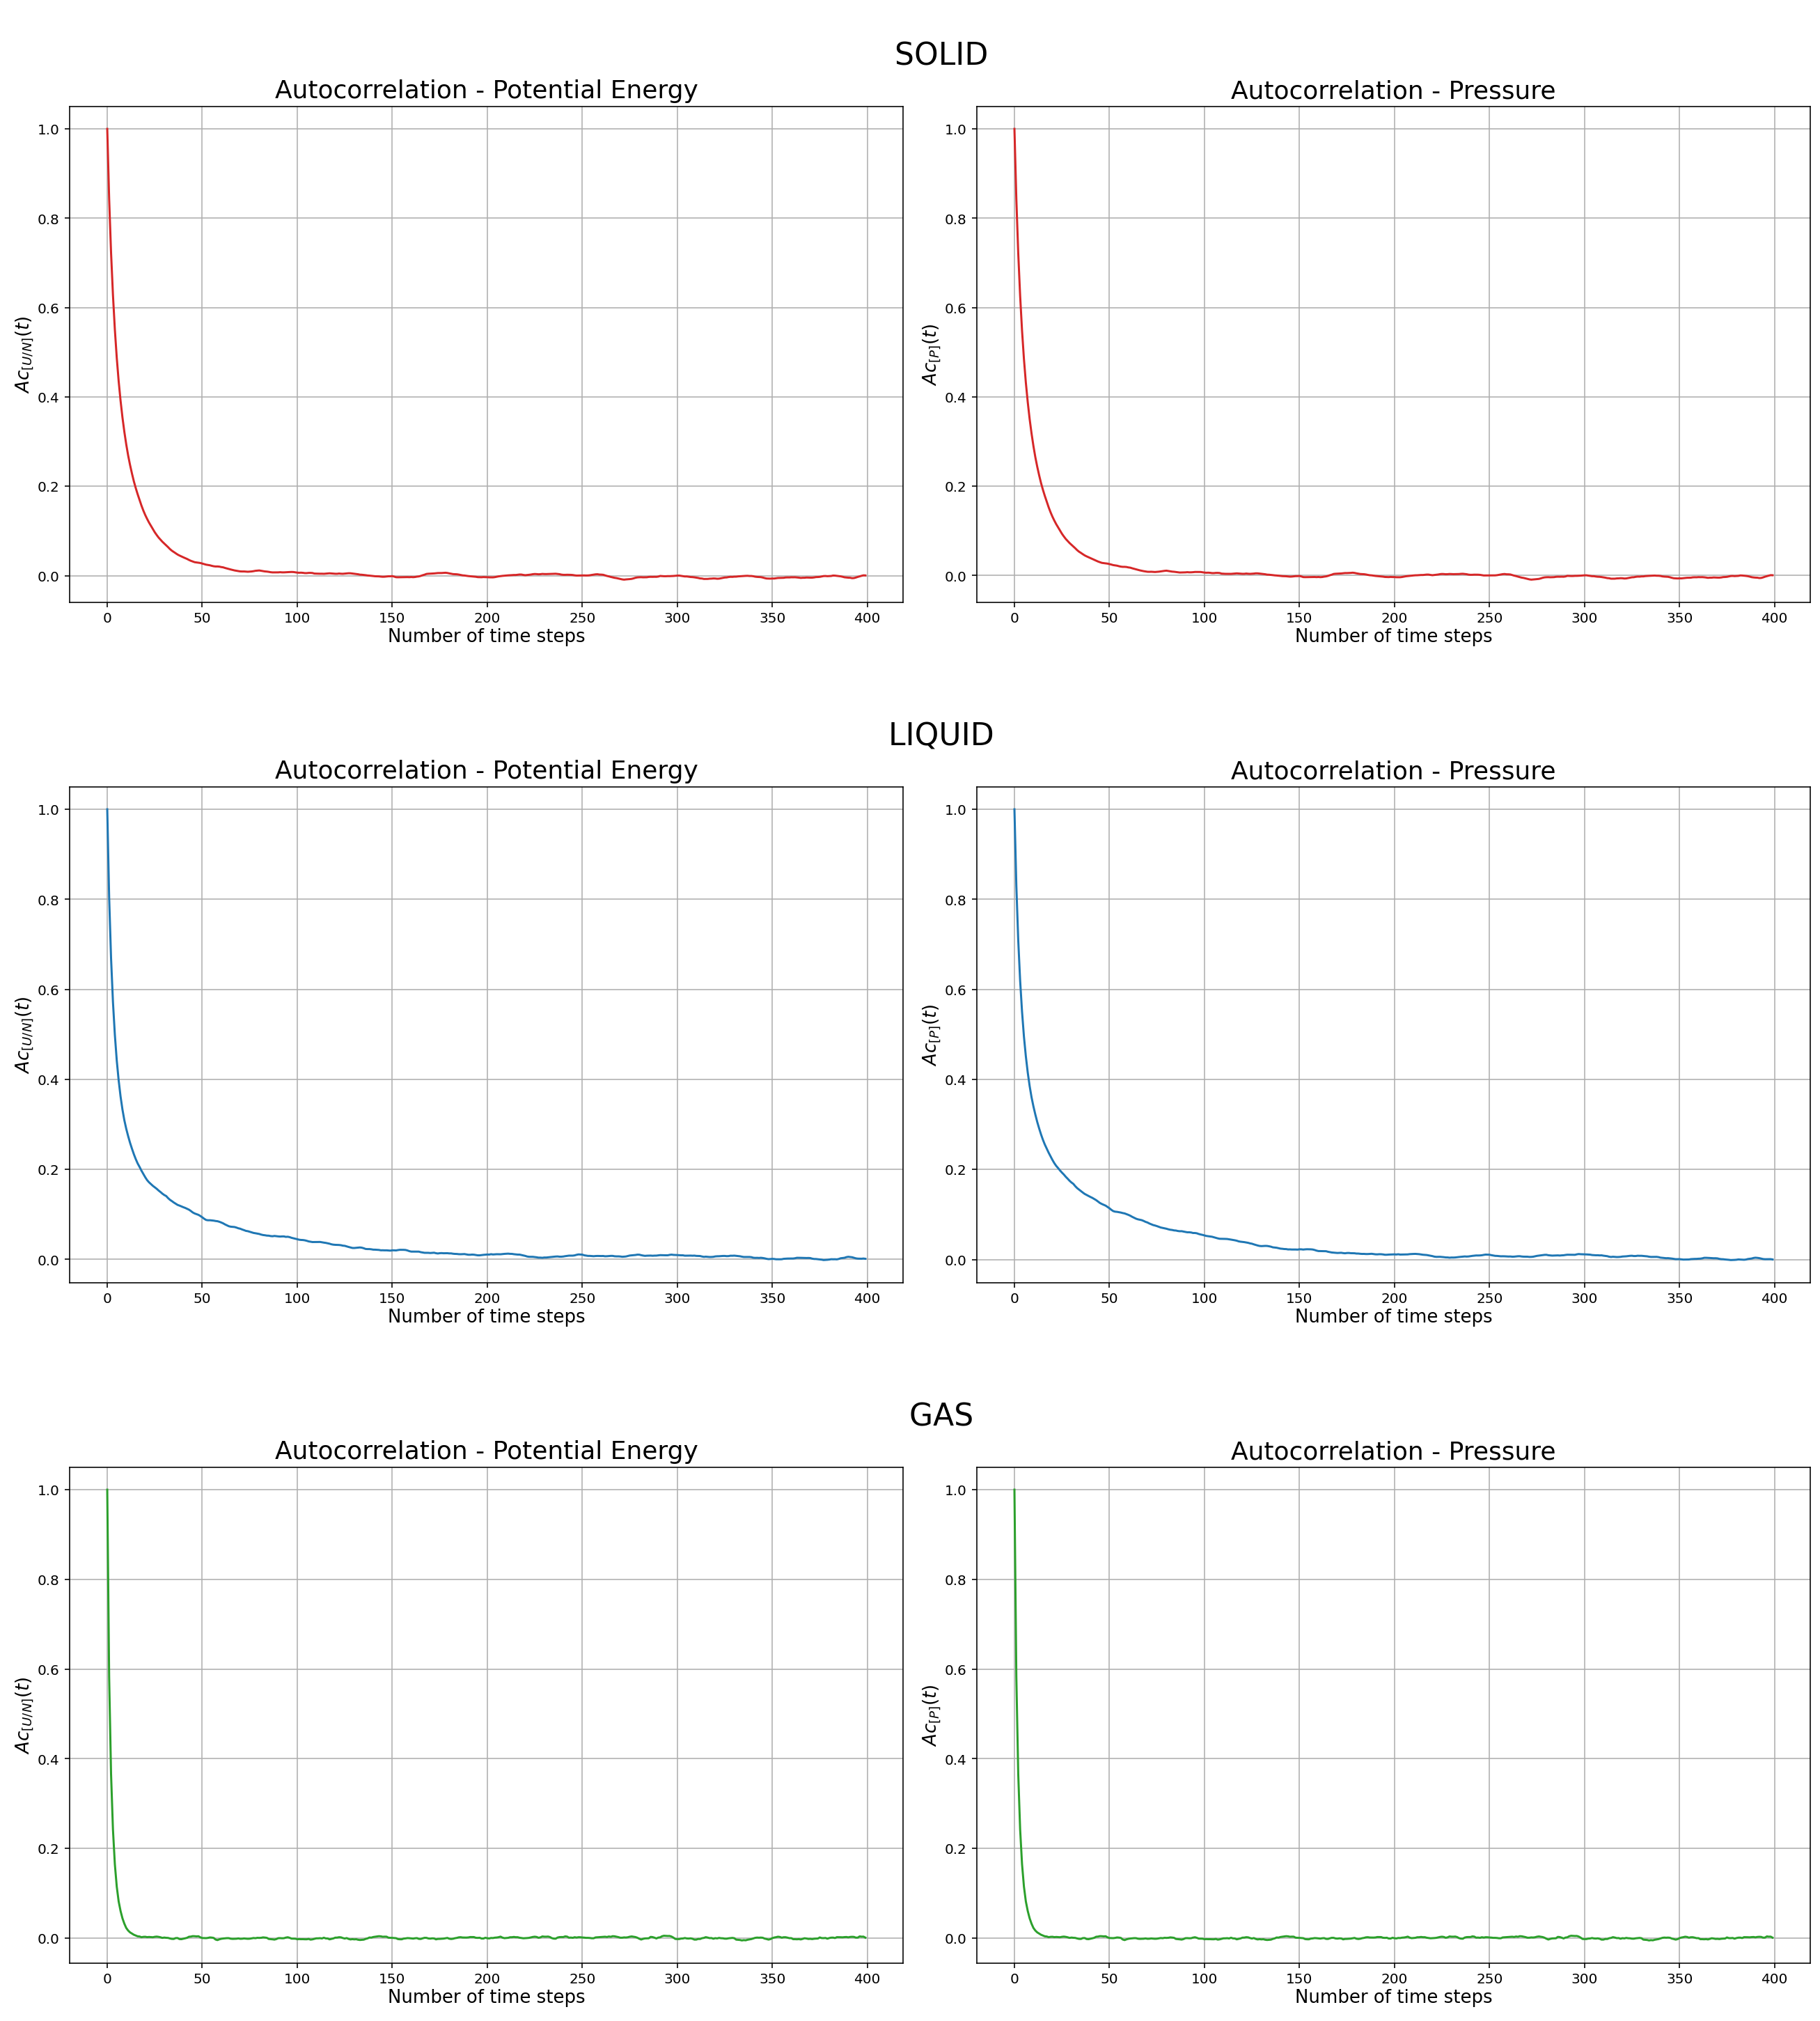

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(18, 20))
fig.suptitle('  ', fontsize='xx-large')

bigtitle_list = ['SOLID', 'LIQUID', 'GAS']
title_list = ['Autocorrelation - Potential Energy', 'Autocorrelation - Pressure']
y_list = ['$Ac_{[U/N]}(t)$', '$Ac_{[P]}(t)$']
color_list = ['tab:red', 'tab:blue', 'tab:green']

plot_list = [epot_ac_solid, pres_ac_solid, epot_ac_liquid, pres_ac_liquid, epot_ac_gas, epot_ac_gas]
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0.1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'      {bigtitle_list[row]}', fontsize=22)
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        ax.plot(plot_list[col+row*2], color=color_list[row])
        ax.set_xlabel(r'Number of time steps', fontsize=13)
        ax.set_ylabel(f'{y_list[col]}', fontsize=13)
        ax.set_title(f'{title_list[col]}', fontsize=18)
        ax.grid(True)

La fase liquida è quella in cui le configurazioni rimangono correlate per un numero maggiore di step temporali, circa $200$. Al contrario, nella fase gassosa si ha correlazione per meno di $20$ step temporali, molto meno rispetto alle altri fasi: questo è probabilmente legato al grande valore assegnato al parametro $\delta$ in questa fase.

Per ottenere risultati precisi, come quelli appena mostrati, è importante che il numero di dati a disposizione sia ben più ampio rispetto alla massima distanza temporale alla quale viene calcolata la funzione di autocorrelazione. Infatti, se calcoliamo la correlazione per valori di $t$ fino a $5000$ usando solamente i primi $5000$ dati, quando $t$ si avvicina a $t_{max}$ sono presenti fluttuazioni sempre più grandi e la stima della correlazione è molto imprecisa, come mostrato nel seguente grafico.

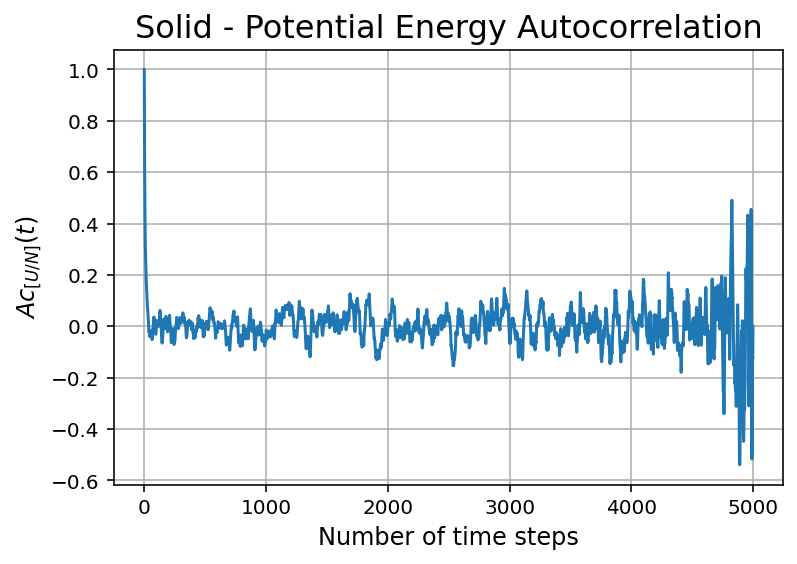

In [7]:
epot_ac_solid_1 = ACF(epot_solid, 5000, 5000)

fig = plt.figure(figsize=(6, 4))
plt.plot(epot_ac_solid_1)
plt.xlabel('Number of time steps', fontsize=12)
plt.ylabel(r'$Ac_{[U/N]}(t)$', fontsize=12)
plt.title('Solid - Potential Energy Autocorrelation', fontsize=16)
plt.grid(True)
plt.show()

Con gli stessi dati, analizziamo ora come varia l'<b>incertezza statistica</b> al variare della dimensione dei blocchi. Di seguito sono riportati i risultati ottenuti per blocchi la cui lunghezza varia da $10$ fino a $5000$.

In [8]:
def block_err (x,L):
    nblock = (int)(x.size/L)
    block_ave = np.zeros(nblock)
    for iblock in range(nblock):
        block_ave[iblock] = np.sum(x[iblock*L:(iblock+1)*L])/L
    return np.sqrt((np.sum(block_ave*block_ave)/nblock-(np.sum(block_ave)/nblock)**2)/nblock)

In [9]:
L = np.arange(10, 5001, 10) # Block Length
errors_epot_solid = np.zeros(len(L))
errors_pres_solid = np.zeros(len(L))

for i in range(len(L)):
    errors_epot_solid[i] = block_err(epot_solid,L[i])
    errors_pres_solid[i] = block_err(pres_solid,L[i])
    
errors_epot_liquid = np.zeros(len(L))
errors_pres_liquid = np.zeros(len(L))

for i in range(len(L)):
    errors_epot_liquid[i] = block_err(epot_liquid,L[i])
    errors_pres_liquid[i] = block_err(pres_liquid,L[i])
    
errors_epot_gas = np.zeros(len(L))
errors_pres_gas = np.zeros(len(L))

for i in range(len(L)):
    errors_epot_gas[i] = block_err(epot_gas,L[i])
    errors_pres_gas[i] = block_err(pres_gas,L[i])

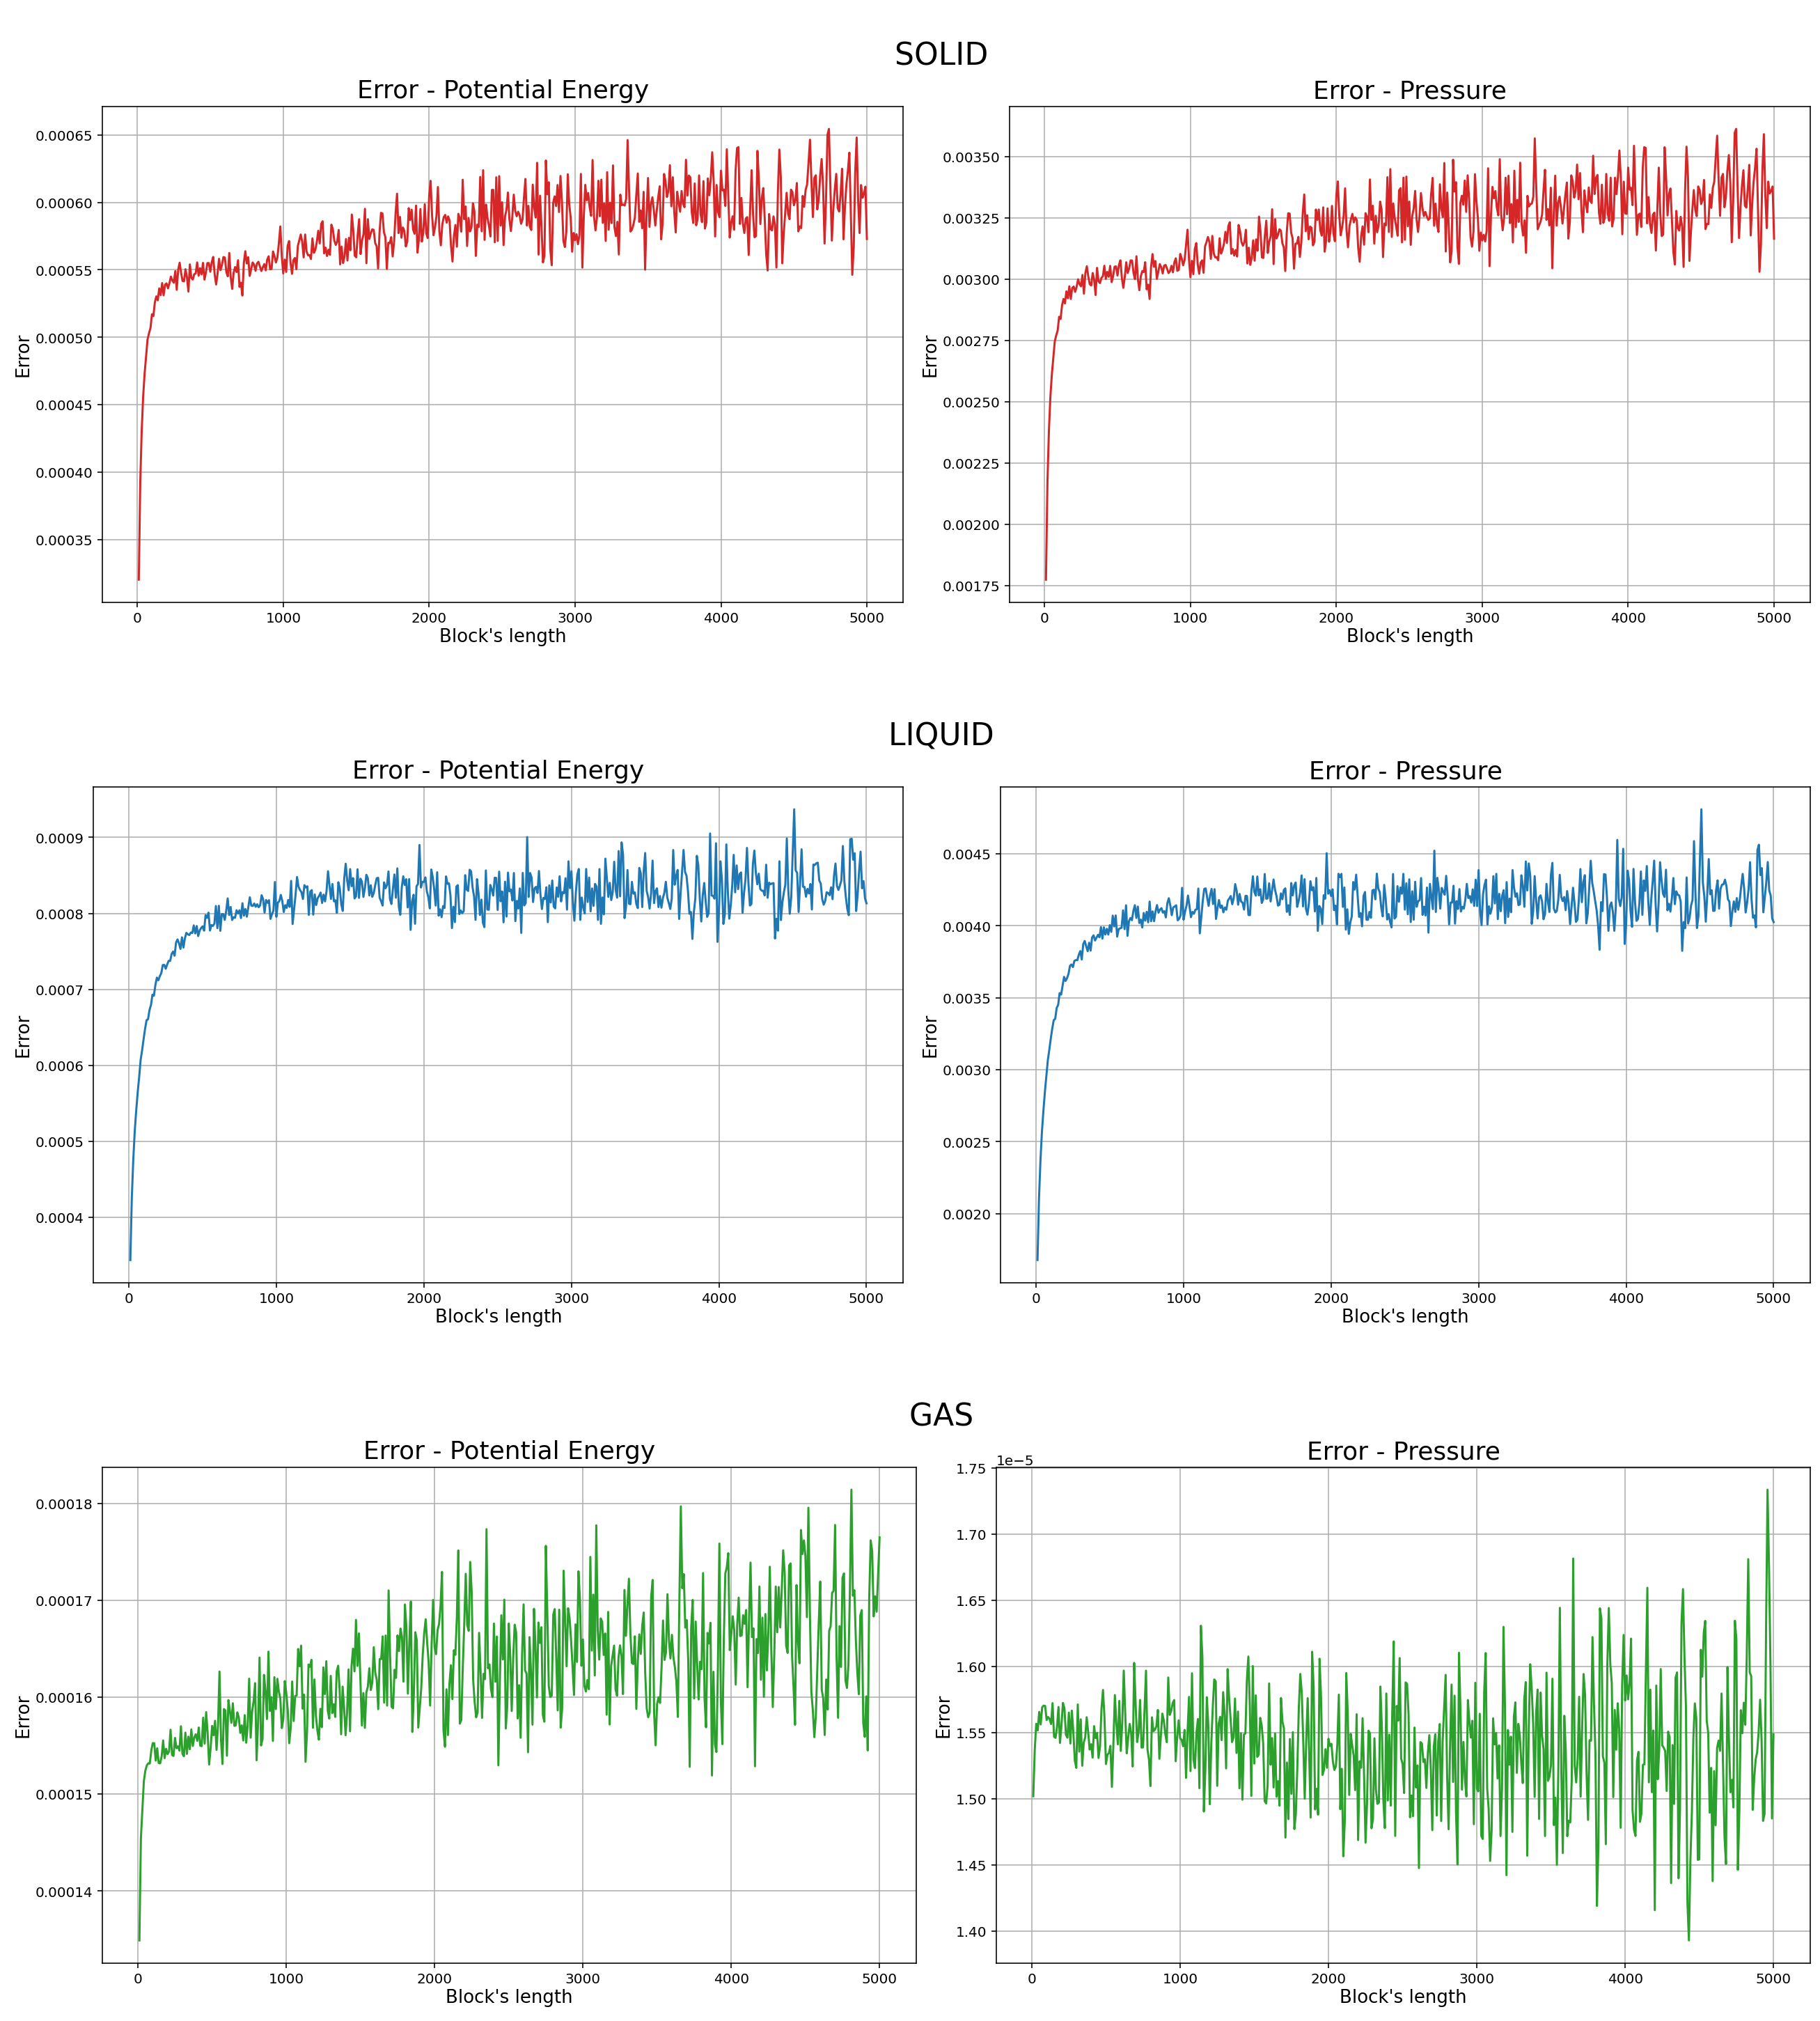

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(18, 20))
fig.suptitle('  ', fontsize='xx-large')

bigtitle_list = ['SOLID', 'LIQUID', 'GAS']
title_list = ['Error - Potential Energy', 'Error - Pressure']
color_list = ['tab:red', 'tab:blue', 'tab:green']

plot_list = [errors_epot_solid, errors_pres_solid, errors_epot_liquid, errors_pres_liquid, errors_epot_gas, errors_pres_gas]
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0.1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'      {bigtitle_list[row]}', fontsize=22)
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        ax.plot(L, plot_list[col+row*2], color=color_list[row])
        ax.set_xlabel(r"Block's length", fontsize=13)
        ax.set_ylabel(r'Error', fontsize=13)
        ax.set_title(f'{title_list[col]}', fontsize=18)
        ax.grid(True)

Come si vede dai grafici qui sopra, quando la lunghezza dei blocchi è troppo piccola si ha una sottostima dell'incertezza statistica, a causa della correlazione tra le configurazioni generate dall'algoritmo. Questa sottostima dell'errore statistico è meno evidente nel caso gassoso a causa della minor correlazione. All'aumentare della lunghezza dei blocchi, come si osserva soprattutto nei casi solido e liquido, la curva dell'errore inizia a saturare, raggiungendo il vero errore statistico. 

Da queste analisi concludiamo che $5000$ è un valore adeguato per la dimensione dei blocchi in tutte e tre le fasi. 

### Esercizi 7.2-7.3-7.4

In questo esercizio viene incluso nel codice il calcolo della funzione di distribuzione radiale a coppie del sistema $g(r)$ con $r \in [0, L/2]$: tale intervallo viene diviso in $100$ bin e ad ogni passo dell'algoritmo si calcola la distanza tra tutte le coppie di particelle, andando ad incrementare di $2$ il bin relativo a tale distanza. Infine viene normalizzato l'istogramma dividendo per il fattore $\rho N \Delta V(r)$, dove $N$ è il numero di particelle del sistema e $\Delta V(r)$ è la differenza di volume tra la sfera di raggio $r+dr$ e quella di raggio $r$. <br>
Lo stesso calcolo viene incluso anche nel codice di Dinamica Molecolare utilizzato nella quarta esercitazione.

Una volta aggiornato il codice è stato simulato il sistema: per tutte e tre le fasi vengono misurate $U/N$, $P$ e $g(r)$ utilizzando $100$ blocchi da $5000$ step ciascuno. Di seguito sono riportate le stime di energia potenziale per particella e pressione con le relative incertezze statistiche al variare del numero di blocchi.

In [11]:
block = np.loadtxt("MonteCarlo_NVT/Solid/output.epot.0", usecols=(0))

#solid
epot_block_solid, epot_av_solid, epot_err_solid = np.loadtxt("MonteCarlo_NVT/Solid/output.epot.0", usecols=(1,2,3), delimiter=' ', unpack='true')*e
pres_block_solid, pres_av_solid, pres_err_solid = np.loadtxt("MonteCarlo_NVT/Solid/output.pres.0", usecols=(1,2,3), delimiter=' ', unpack='true')*p
g_av_solid, g_err_solid = np.loadtxt("MonteCarlo_NVT/Solid/output.gave.0", usecols=(1,2), delimiter=' ', unpack='true')

#liquid
epot_block_liquid, epot_av_liquid, epot_err_liquid = np.loadtxt("MonteCarlo_NVT/Liquid/output.epot.0", usecols=(1,2,3), delimiter=' ', unpack='true')*e
pres_block_liquid, pres_av_liquid, pres_err_liquid = np.loadtxt("MonteCarlo_NVT/Liquid/output.pres.0", usecols=(1,2,3), delimiter=' ', unpack='true')*p
g_av_liquid, g_err_liquid = np.loadtxt("MonteCarlo_NVT/Liquid/output.gave.0", usecols=(1,2), delimiter=' ', unpack='true')

#gas
epot_block_gas, epot_av_gas, epot_err_gas = np.loadtxt("MonteCarlo_NVT/Gas/output.epot.0", usecols=(1,2,3), delimiter=' ', unpack='true')*e
pres_block_gas, pres_av_gas, pres_err_gas = np.loadtxt("MonteCarlo_NVT/Gas/output.pres.0", usecols=(1,2,3), delimiter=' ', unpack='true')*p
g_av_gas, g_err_gas = np.loadtxt("MonteCarlo_NVT/Gas/output.gave.0", usecols=(1,2), delimiter=' ', unpack='true')

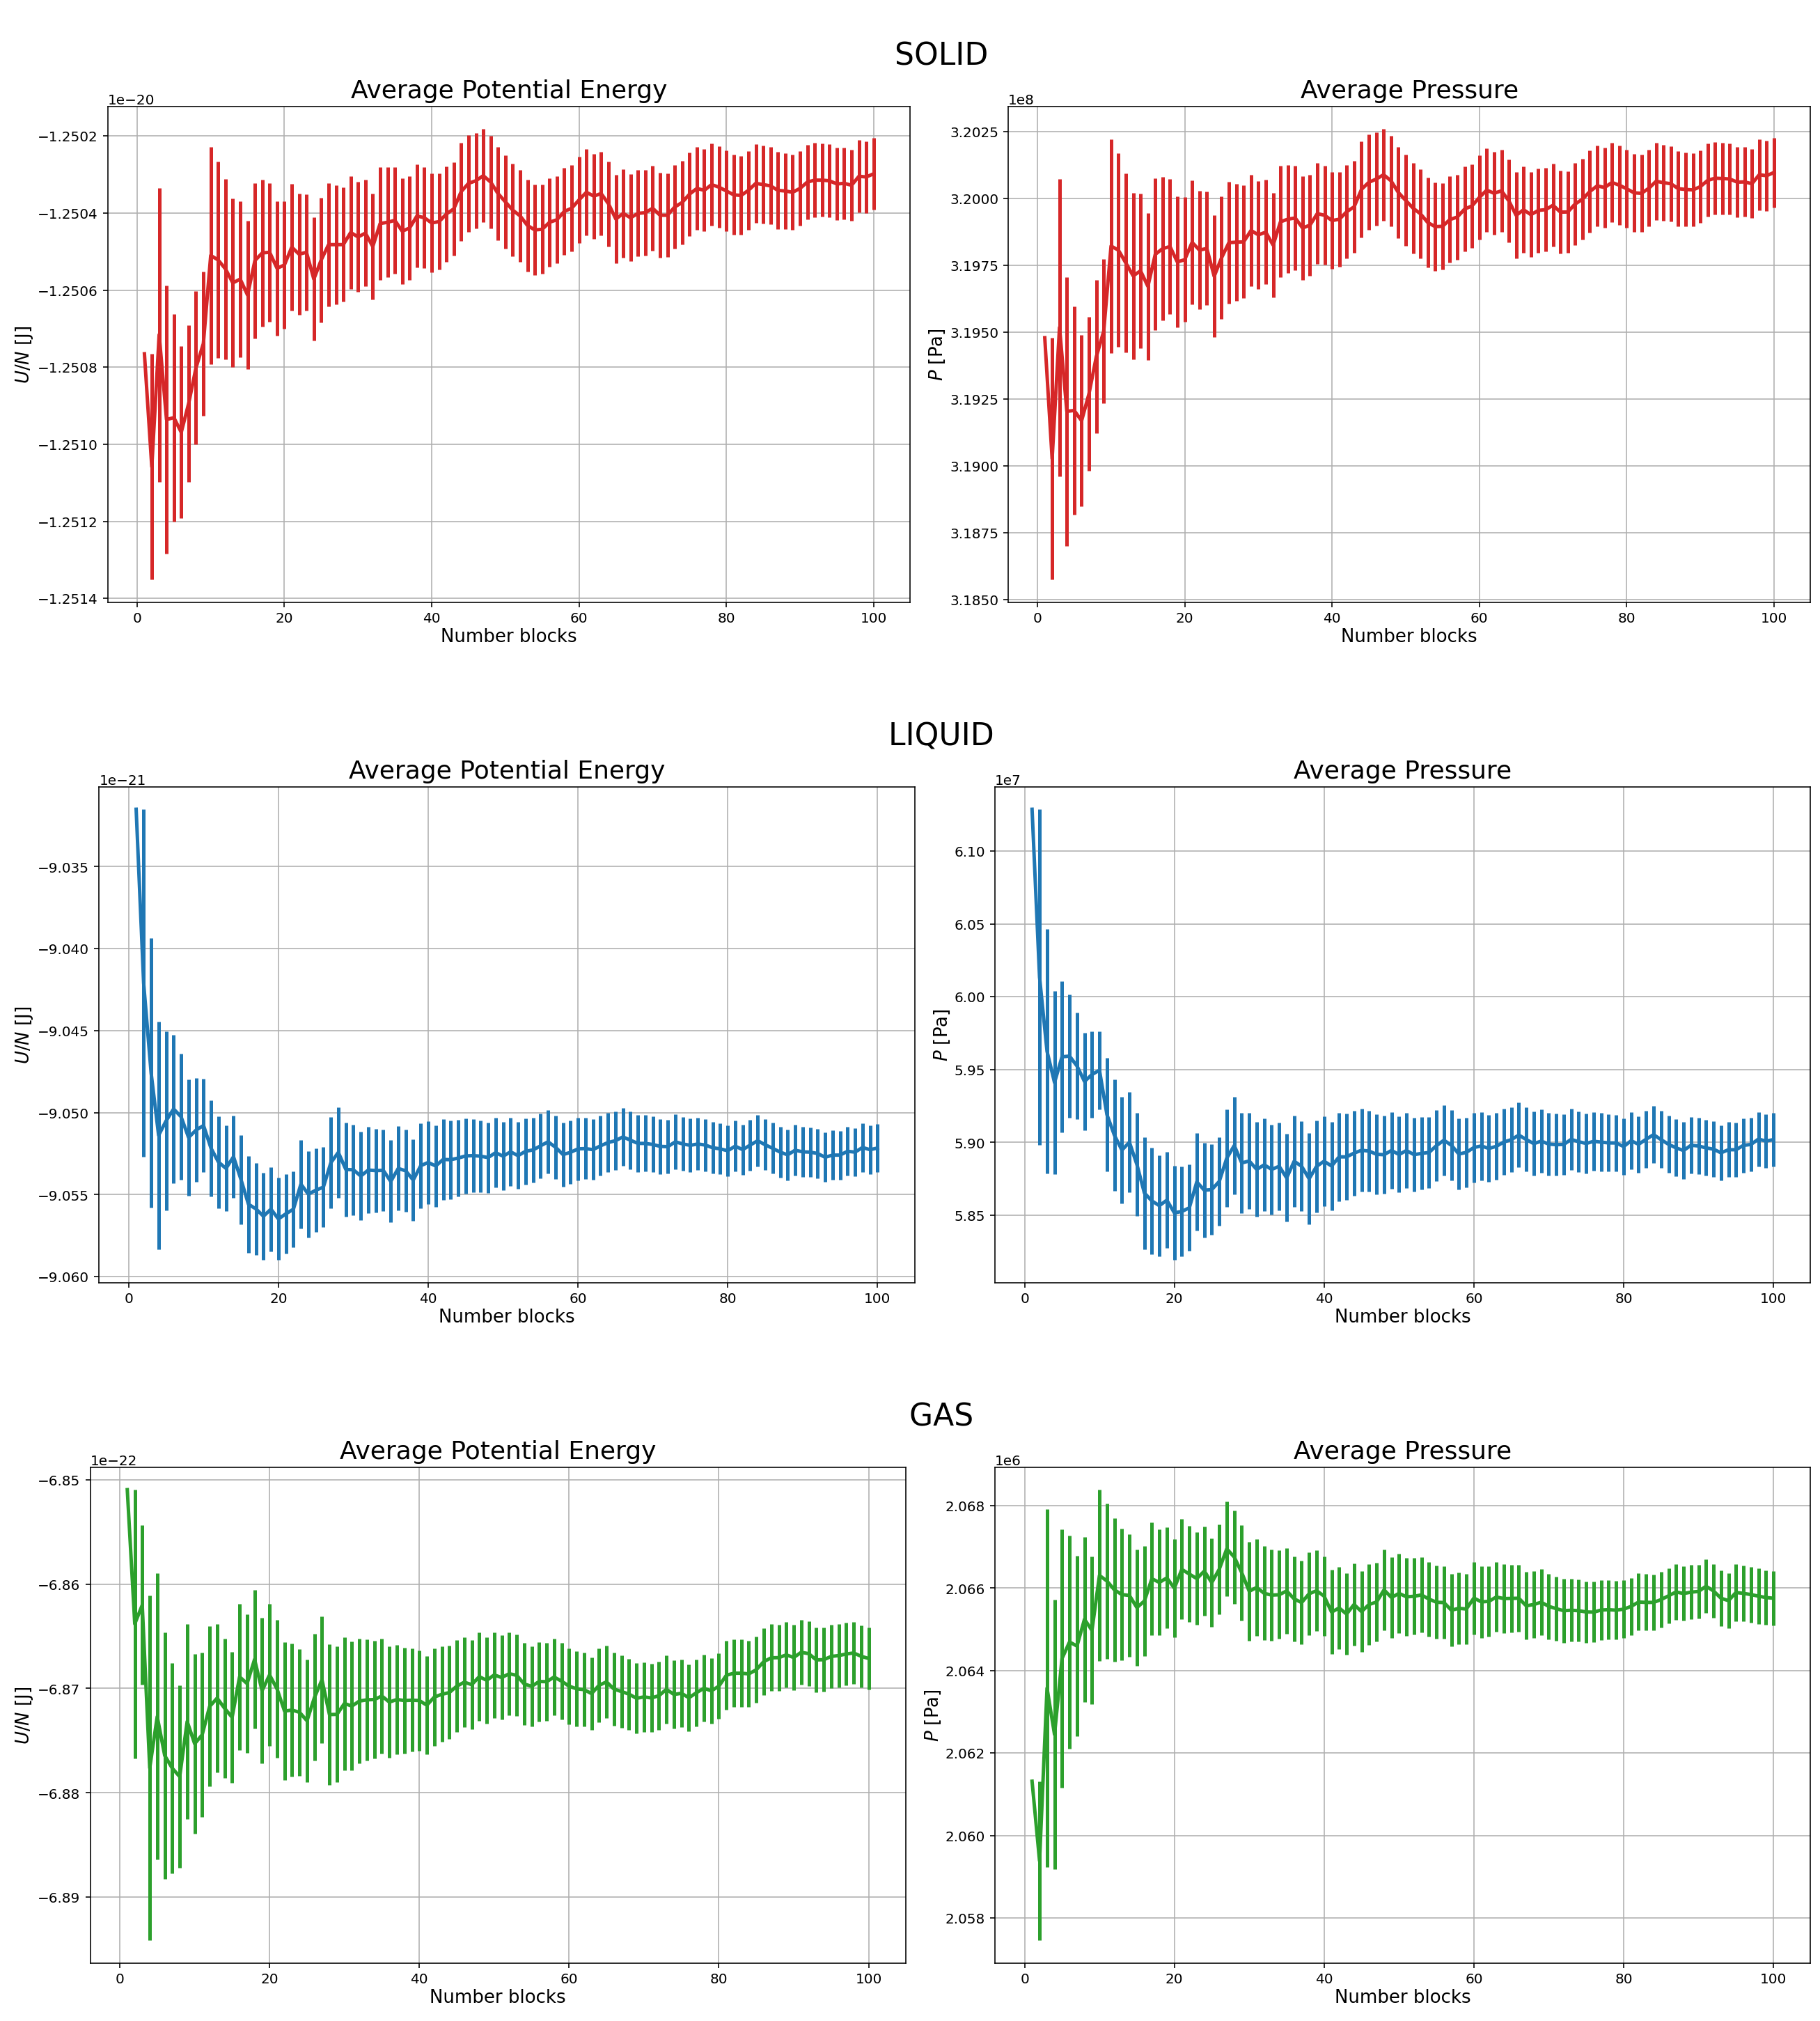

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(18, 20))
fig.suptitle('  ', fontsize='xx-large')

bigtitle_list = ['SOLID', 'LIQUID', 'GAS']
title_list = ['Average Potential Energy', 'Average Pressure']
y_list = ['$U/N$ [J]', '$P$ [Pa]']

color_list = ['tab:red', 'tab:blue', 'tab:green']
c_list = ['lightgreen', 'tab:orange', 'tab:purple']
av_list = [epot_av_solid, pres_av_solid, epot_av_liquid, pres_av_liquid, epot_av_gas, pres_av_gas]
err_list = [epot_err_solid, pres_err_solid, epot_err_liquid, pres_err_liquid, epot_err_gas, pres_err_gas]
plot_list = [epot_block_solid, pres_block_solid, epot_block_liquid, pres_block_liquid, epot_block_gas, pres_block_gas]
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0.1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'      {bigtitle_list[row]}', fontsize=22)
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        ax.errorbar(block, av_list[col+row*2], yerr=err_list[col+row*2], color=color_list[row], lw=2.5)
        #ax.plot(block, plot_list[col+row*2], color=c_list[row], lw=0.8)
        ax.set_xlabel(r'Number blocks', fontsize=13)
        ax.set_ylabel(f'{y_list[col]}', fontsize=13)
        ax.set_title(f'{title_list[col]}', fontsize=18)
        ax.grid(True)

Di seguito vengono riportati per le tre fasi i grafici di $g(r)$ al variare di $r$ nell'intervallo considerato, confrontando i risultati ottenuti tramite i due codici.

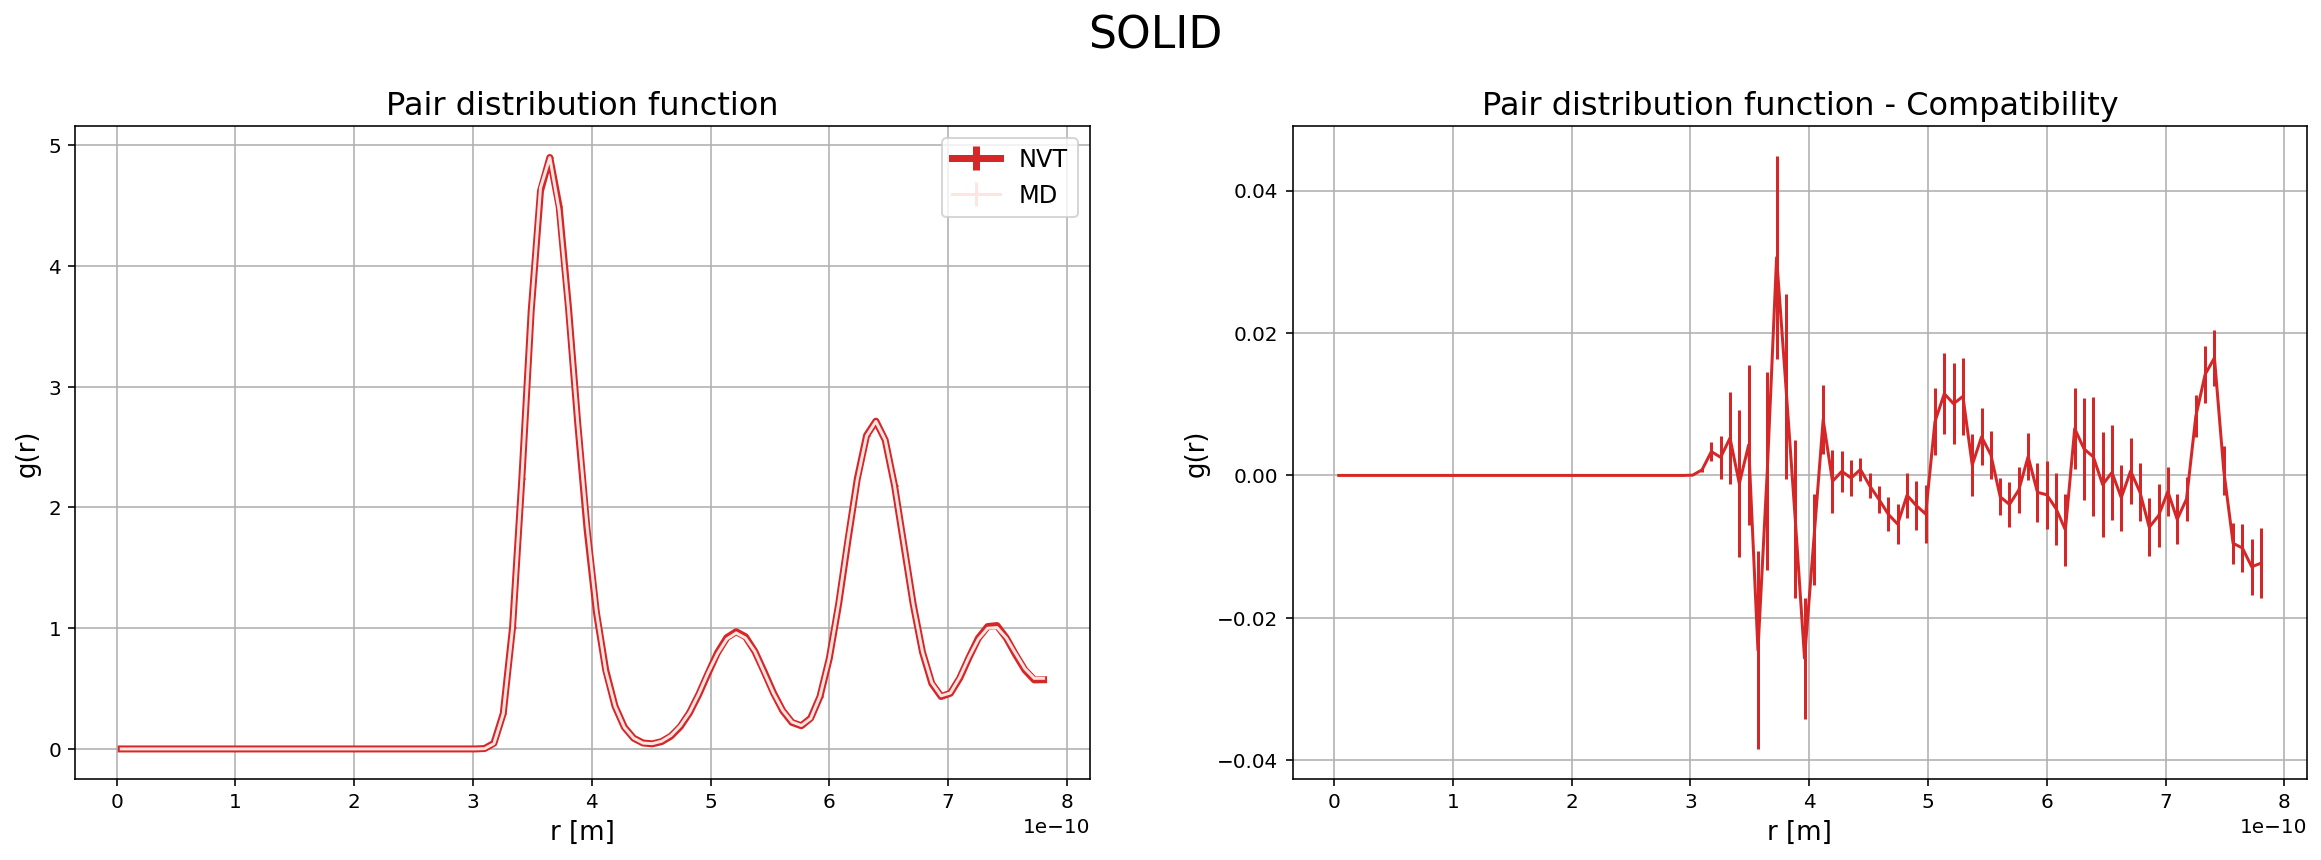

In [13]:
r = np.loadtxt("MonteCarlo_NVT/Solid/output.gave.0", usecols=(0))*sigma
g_av_MD_solid, g_err_MD_solid = np.loadtxt("MD/solid_gr/gave.out", usecols=(1,2), delimiter=' ', unpack='true')

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.reshape(-1)
fig.suptitle(f'SOLID', fontsize=22, y=1.01)

ax[0].errorbar(r, g_av_solid, yerr=g_err_solid, color='tab:red', label='NVT', lw=3.5)
ax[0].errorbar(r, g_av_MD_solid, yerr=g_err_MD_solid, color='mistyrose', label='MD')
ax[0].set_xlabel('r [m]', fontsize=13)
ax[0].set_ylabel('g(r)', fontsize=13)
ax[0].legend(loc='upper right', fontsize=12)
ax[0].set_title(f'Pair distribution function', fontsize=16)
ax[0].grid(True)

g_diff_err = np.sqrt(g_err_MD_solid**2+g_err_solid**2)

ax[1].errorbar(r, g_av_solid-g_av_MD_solid, yerr=g_diff_err, color='tab:red')
ax[1].set_xlabel('r [m]', fontsize=13)
ax[1].set_ylabel('g(r)', fontsize=13)
ax[1].set_title(f'Pair distribution function - Compatibility', fontsize=16)
ax[1].grid(True)

plt.show()

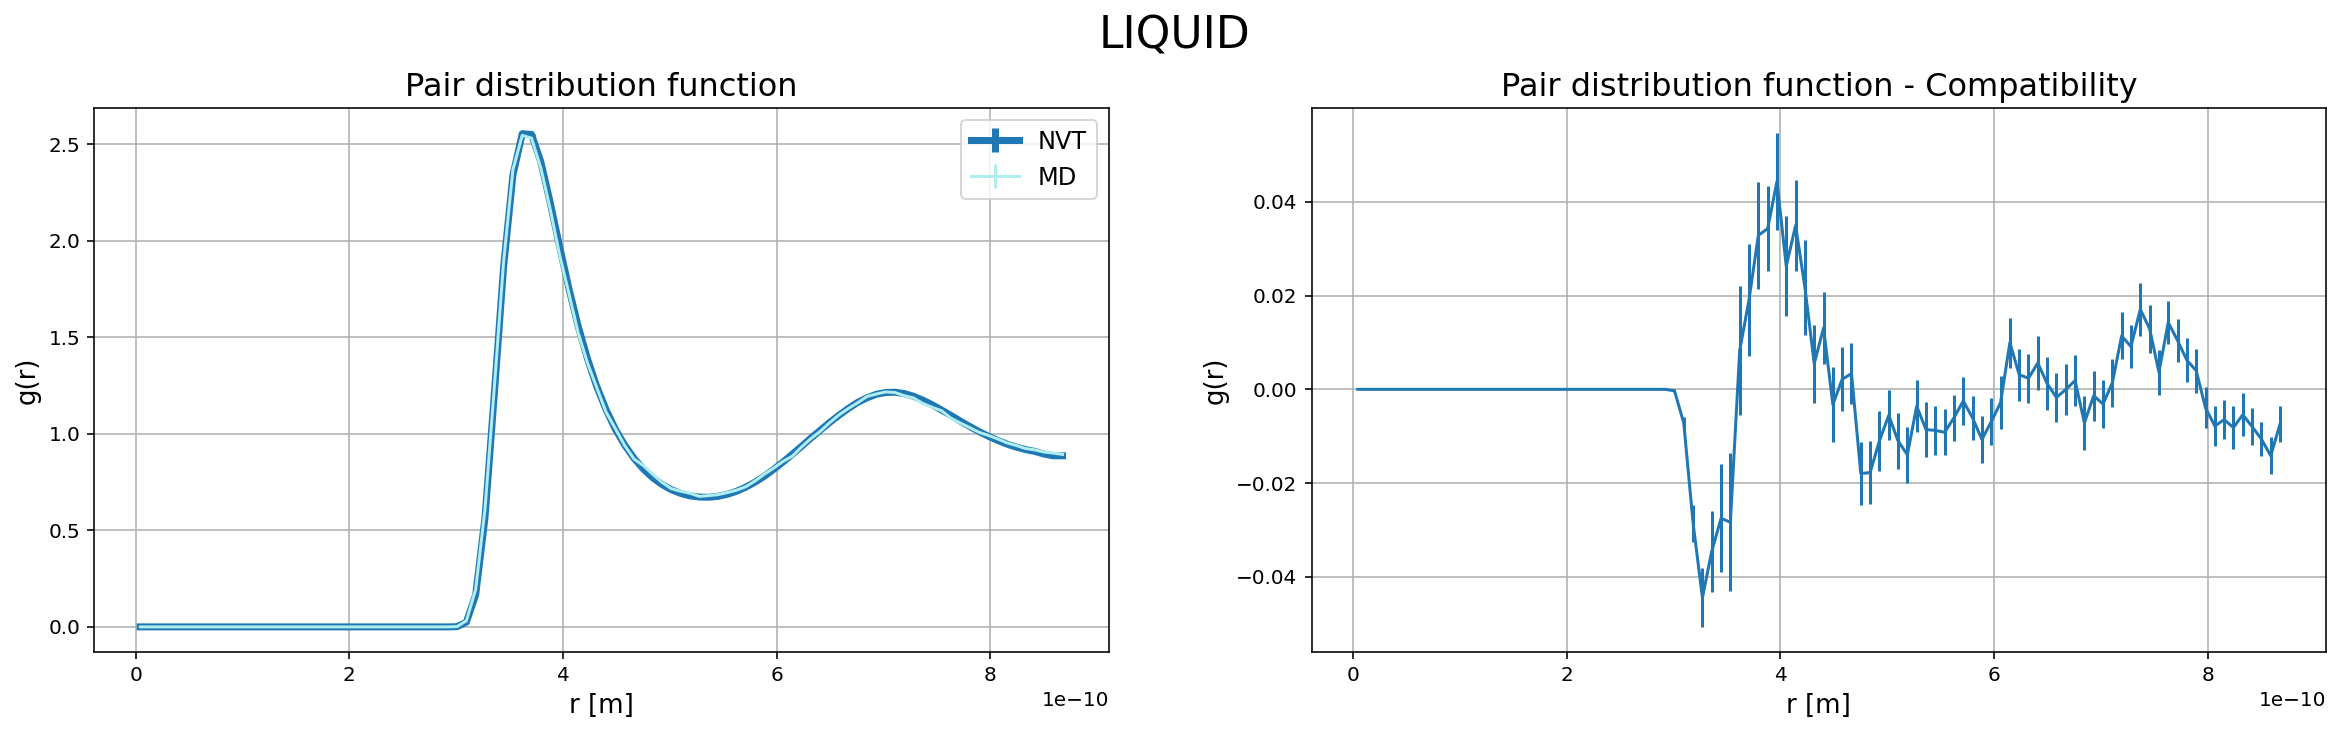

In [14]:
r = np.loadtxt("MonteCarlo_NVT/Liquid/output.gave.0", usecols=(0))*sigma
g_av_MD_liquid, g_err_MD_liquid = np.loadtxt("MD/liquid_gr/gave.out", usecols=(1,2), delimiter=' ', unpack='true')

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.reshape(-1)
fig.suptitle(f'LIQUID', fontsize=22, y=1.01)

ax[0].errorbar(r, g_av_liquid, yerr=g_err_liquid, color='tab:blue', label='NVT', lw=3.5)
ax[0].errorbar(r, g_av_MD_liquid, yerr=g_err_MD_liquid, label='MD', color='paleturquoise')
ax[0].set_xlabel('r [m]', fontsize=13)
ax[0].set_ylabel('g(r)', fontsize=13)
ax[0].set_title(f'Pair distribution function', fontsize=16)
ax[0].legend(loc='upper right', fontsize=12)
ax[0].grid(True)

g_diff_err = np.sqrt(g_err_MD_liquid**2+g_err_liquid**2)

ax[1].errorbar(r, g_av_liquid-g_av_MD_liquid, yerr=g_diff_err, color='tab:blue')
ax[1].set_xlabel('r [m]', fontsize=13)
ax[1].set_ylabel('g(r)', fontsize=13)
ax[1].set_title(f'Pair distribution function - Compatibility', fontsize=16)
ax[1].grid(True)

plt.show()

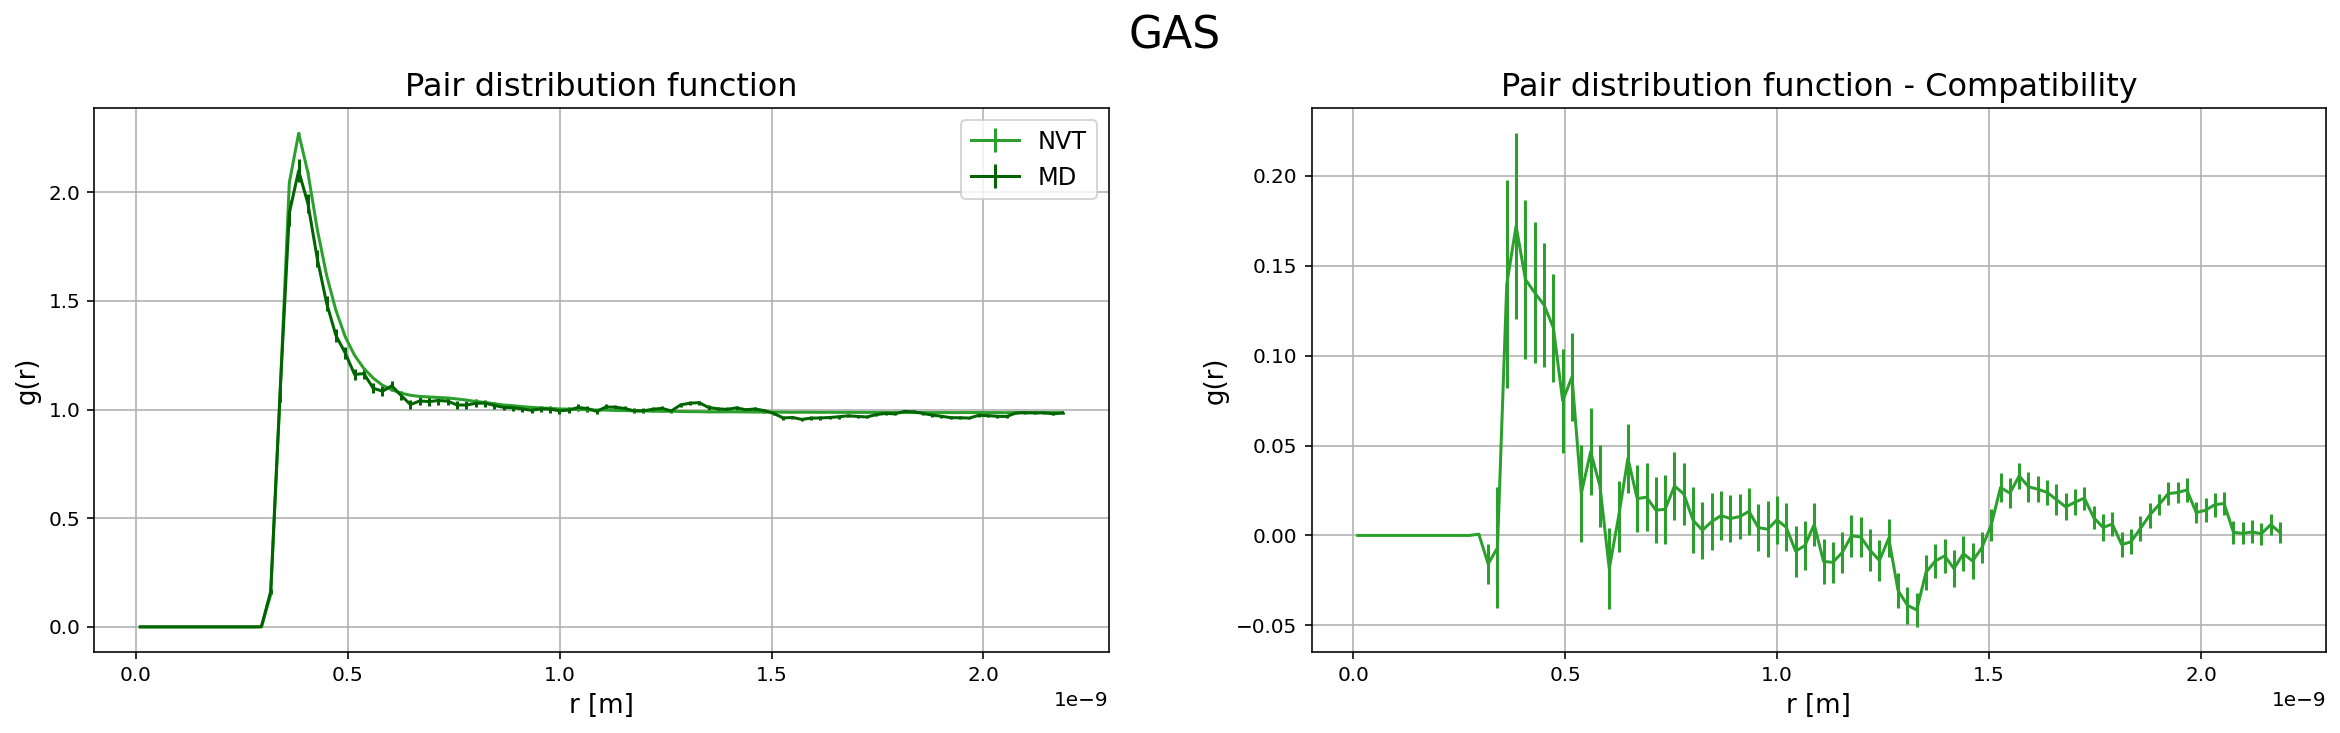

In [15]:
r = np.loadtxt("MonteCarlo_NVT/Gas/output.gave.0", usecols=(0))*sigma
g_av_MD_gas, g_err_MD_gas = np.loadtxt("MD/gas_gr/gave.out", usecols=(1,2), delimiter=' ', unpack='true')

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.reshape(-1)
fig.suptitle(f'GAS', fontsize=22, y=1.01)

ax[0].errorbar(r, g_av_gas, yerr=g_err_gas, color='tab:green', label='NVT')
ax[0].errorbar(r, g_av_MD_gas, yerr=g_err_MD_gas, color='darkgreen', label='MD')
ax[0].set_xlabel('r [m]', fontsize=13)
ax[0].set_ylabel('g(r)', fontsize=13)
ax[0].set_title(f'Pair distribution function', fontsize=16)
ax[0].legend(loc='upper right', fontsize=12)
ax[0].grid(True)

g_diff_err = np.sqrt(g_err_MD_gas**2+g_err_gas**2)

ax[1].errorbar(r, g_av_gas-g_av_MD_gas, yerr=g_diff_err, color='tab:green')
ax[1].set_xlabel('r [m]', fontsize=13)
ax[1].set_ylabel('g(r)', fontsize=13)
ax[1].set_title(f'Pair distribution function - Compatibility', fontsize=16)
ax[1].grid(True)

plt.show()

I risultati ottenuti dai due codici non sempre risultano compatibili entro l'incertezza statistica, soprattutto nella fase gassossa. In ogni caso la funzione $g(r)$ ha lo stesso andamento in entrambi i tipi di simulazione e questo significa che il sistema simulato si comporta nello stesso modo in entrambi i casi.